__COMP47970 Project__ • Anthony Salib 20341603

---

# Data Preparation for Visualisation of the 'TikTok-ification' of Music

The goal of this assignment is to use a dataset obtained from the [Spotify API](https://developer.spotify.com/documentation/web-api/), and to investigate the factors that contribute to the 'TikTokification' of music.

This notebook covers the **Task of Data Preparing and Processing** the data we collected. 

---


### Preliminary Work
Importing necessary packages used

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm


## Data Preprocessing

### Data Loading
Import the raw CSV files into respective dataframes. Each dataframe will need to be merged since our analysis will require information from both datasets. This can be done with the common key between them `track ID`, using an inner join to ensure we only work with tracks in both datasets. 

In [4]:
folder_path = 'bin/'
tracks_df = pd.read_csv(folder_path + 'tracks.csv')
audio_features_df = pd.read_csv(folder_path + 'audio_features.csv')
tracks_df.head() # ensure proper file reading

,Track ID,Track name,Artist name,Popularity,Release year,Category
0,6DshyLFOY859M1ERk0h54h,New Release,Killing Time,22,1989,New Releases
1,4DZghpw50ZnO3ckfDuNkft,New Religion,The Heydaze,53,2017,New Releases
2,0KbTsCQkdNGnkrea1vA4eG,Morning Has Broken (New Release) (with Diana K...,Art Garfunkel,43,2002,New Releases
3,0lmRKkc33g1N9fWW9nZPVc,"New Recording 12, Jan 3, 2020",Post Malone,46,2022,New Releases
4,3eluHrktBbrs9qCnfRcJkm,Relieve Him of His Wand / Newt Releases the Th...,James Newton Howard,31,2016,New Releases


#### Merging Data
The goal is to combine the data from both DataFrames into a single DataFrame based on a common key, `track ID`, which is represented by the `Track ID` column in `tracks_df` and `id` column in `audio_features_df`.

In [5]:
merged_df = tracks_df.merge(audio_features_df, left_on='Track ID', right_on='id',how='inner')
merged_df.head() # ensure properties (columns) are merged properly

,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,6DshyLFOY859M1ERk0h54h,New Release,Killing Time,22,1989,New Releases,0.322,0.7140,4,-13.477,...,0.0984,0.3780,125.286,audio_features,6DshyLFOY859M1ERk0h54h,spotify:track:6DshyLFOY859M1ERk0h54h,https://api.spotify.com/v1/tracks/6DshyLFOY859...,https://api.spotify.com/v1/audio-analysis/6Dsh...,101960,4
1,4DZghpw50ZnO3ckfDuNkft,New Religion,The Heydaze,53,2017,New Releases,0.537,0.8630,7,-4.460,...,0.2010,0.4840,97.020,audio_features,4DZghpw50ZnO3ckfDuNkft,spotify:track:4DZghpw50ZnO3ckfDuNkft,https://api.spotify.com/v1/tracks/4DZghpw50ZnO...,https://api.spotify.com/v1/audio-analysis/4DZg...,203587,4
2,0KbTsCQkdNGnkrea1vA4eG,Morning Has Broken (New Release) (with Diana K...,Art Garfunkel,43,2002,New Releases,0.253,0.2060,2,-14.276,...,0.1190,0.2280,105.480,audio_features,0KbTsCQkdNGnkrea1vA4eG,spotify:track:0KbTsCQkdNGnkrea1vA4eG,https://api.spotify.com/v1/tracks/0KbTsCQkdNGn...,https://api.spotify.com/v1/audio-analysis/0KbT...,175227,3
3,0lmRKkc33g1N9fWW9nZPVc,"New Recording 12, Jan 3, 2020",Post Malone,46,2022,New Releases,0.477,0.1620,9,-15.340,...,0.1790,0.2110,106.144,audio_features,0lmRKkc33g1N9fWW9nZPVc,spotify:track:0lmRKkc33g1N9fWW9nZPVc,https://api.spotify.com/v1/tracks/0lmRKkc33g1N...,https://api.spotify.com/v1/audio-analysis/0lmR...,92718,3
4,3eluHrktBbrs9qCnfRcJkm,Relieve Him of His Wand / Newt Releases the Th...,James Newton Howard,31,2016,New Releases,0.117,0.0799,5,-18.385,...,0.0988,0.0341,85.353,audio_features,3eluHrktBbrs9qCnfRcJkm,spotify:track:3eluHrktBbrs9qCnfRcJkm,https://api.spotify.com/v1/tracks/3eluHrktBbrs...,https://api.spotify.com/v1/audio-analysis/3elu...,753202,4


#### Adressing Duplicate Data Entries
When we consolidate these two dataframes into a single one, we risk creating duplicate entries - especially where there are multiple versions of the same track that have the same Track ID. Duplicate entries can skew our results by giving undue weight to repeated entires and must be handled appropriately.

In [6]:
unique_df = merged_df.drop_duplicates(subset='Track ID', keep='first')
unique_df.duplicated(subset=['Track ID']).any() # check if there are any duplicate Track IDs left

np.False_

#### Data Transformation
We convert the unit of time for the duration of each song from milliseconds to minutes. This is to improve readability and is definetly easier to gain insights on song lengths.

In [7]:
# converting 'duration_ms' from ms to mins and round to 2 decimal places
unique_df.loc[:, 'duration'] = unique_df['duration_ms'].apply(lambda x: round((x / 60000), 2))
unique_df.head()

/var/folders/xz/85153ty17sv0zcgxf59_891c0000gn/T/ipykernel_11505/2641234106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df.loc[:, 'duration'] = unique_df['duration_ms'].apply(lambda x: round((x / 60000), 2))


,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,duration
0,6DshyLFOY859M1ERk0h54h,New Release,Killing Time,22,1989,New Releases,0.322,0.7140,4,-13.477,...,0.3780,125.286,audio_features,6DshyLFOY859M1ERk0h54h,spotify:track:6DshyLFOY859M1ERk0h54h,https://api.spotify.com/v1/tracks/6DshyLFOY859...,https://api.spotify.com/v1/audio-analysis/6Dsh...,101960,4,1.70
1,4DZghpw50ZnO3ckfDuNkft,New Religion,The Heydaze,53,2017,New Releases,0.537,0.8630,7,-4.460,...,0.4840,97.020,audio_features,4DZghpw50ZnO3ckfDuNkft,spotify:track:4DZghpw50ZnO3ckfDuNkft,https://api.spotify.com/v1/tracks/4DZghpw50ZnO...,https://api.spotify.com/v1/audio-analysis/4DZg...,203587,4,3.39
2,0KbTsCQkdNGnkrea1vA4eG,Morning Has Broken (New Release) (with Diana K...,Art Garfunkel,43,2002,New Releases,0.253,0.2060,2,-14.276,...,0.2280,105.480,audio_features,0KbTsCQkdNGnkrea1vA4eG,spotify:track:0KbTsCQkdNGnkrea1vA4eG,https://api.spotify.com/v1/tracks/0KbTsCQkdNGn...,https://api.spotify.com/v1/audio-analysis/0KbT...,175227,3,2.92
3,0lmRKkc33g1N9fWW9nZPVc,"New Recording 12, Jan 3, 2020",Post Malone,46,2022,New Releases,0.477,0.1620,9,-15.340,...,0.2110,106.144,audio_features,0lmRKkc33g1N9fWW9nZPVc,spotify:track:0lmRKkc33g1N9fWW9nZPVc,https://api.spotify.com/v1/tracks/0lmRKkc33g1N...,https://api.spotify.com/v1/audio-analysis/0lmR...,92718,3,1.55
4,3eluHrktBbrs9qCnfRcJkm,Relieve Him of His Wand / Newt Releases the Th...,James Newton Howard,31,2016,New Releases,0.117,0.0799,5,-18.385,...,0.0341,85.353,audio_features,3eluHrktBbrs9qCnfRcJkm,spotify:track:3eluHrktBbrs9qCnfRcJkm,https://api.spotify.com/v1/tracks/3eluHrktBbrs...,https://api.spotify.com/v1/audio-analysis/3elu...,753202,4,12.55


#### Data Verification
Now we check for any missing or invalid values in our dataframe.

In [8]:
missing_values = unique_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if len(missing_values) == 0:
    print("No missing values")
else:
    print(missing_values)

No missing values


We can now save the cleaned data to a CSV file

In [9]:
unique_df.to_csv(Path('data')/'cleaned_tracks.csv',index=False)

## Data Analysis

### Data Loading
Load the `clean_tracks.csv` file. This is a redudant step given the `unique_df` is already stored in memory, but it's good practice anyways.

In [12]:
music_df = pd.read_csv(Path('data')/'cleaned_tracks.csv')
music_df.head()

,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,duration
0,6DshyLFOY859M1ERk0h54h,New Release,Killing Time,22,1989,New Releases,0.322,0.7140,4,-13.477,...,0.3780,125.286,audio_features,6DshyLFOY859M1ERk0h54h,spotify:track:6DshyLFOY859M1ERk0h54h,https://api.spotify.com/v1/tracks/6DshyLFOY859...,https://api.spotify.com/v1/audio-analysis/6Dsh...,101960,4,1.70
1,4DZghpw50ZnO3ckfDuNkft,New Religion,The Heydaze,53,2017,New Releases,0.537,0.8630,7,-4.460,...,0.4840,97.020,audio_features,4DZghpw50ZnO3ckfDuNkft,spotify:track:4DZghpw50ZnO3ckfDuNkft,https://api.spotify.com/v1/tracks/4DZghpw50ZnO...,https://api.spotify.com/v1/audio-analysis/4DZg...,203587,4,3.39
2,0KbTsCQkdNGnkrea1vA4eG,Morning Has Broken (New Release) (with Diana K...,Art Garfunkel,43,2002,New Releases,0.253,0.2060,2,-14.276,...,0.2280,105.480,audio_features,0KbTsCQkdNGnkrea1vA4eG,spotify:track:0KbTsCQkdNGnkrea1vA4eG,https://api.spotify.com/v1/tracks/0KbTsCQkdNGn...,https://api.spotify.com/v1/audio-analysis/0KbT...,175227,3,2.92
3,0lmRKkc33g1N9fWW9nZPVc,"New Recording 12, Jan 3, 2020",Post Malone,46,2022,New Releases,0.477,0.1620,9,-15.340,...,0.2110,106.144,audio_features,0lmRKkc33g1N9fWW9nZPVc,spotify:track:0lmRKkc33g1N9fWW9nZPVc,https://api.spotify.com/v1/tracks/0lmRKkc33g1N...,https://api.spotify.com/v1/audio-analysis/0lmR...,92718,3,1.55
4,3eluHrktBbrs9qCnfRcJkm,Relieve Him of His Wand / Newt Releases the Th...,James Newton Howard,31,2016,New Releases,0.117,0.0799,5,-18.385,...,0.0341,85.353,audio_features,3eluHrktBbrs9qCnfRcJkm,spotify:track:3eluHrktBbrs9qCnfRcJkm,https://api.spotify.com/v1/tracks/3eluHrktBbrs...,https://api.spotify.com/v1/audio-analysis/3elu...,753202,4,12.55


### Number of tracks per decade

<Axes: xlabel='count', ylabel='Release year'>

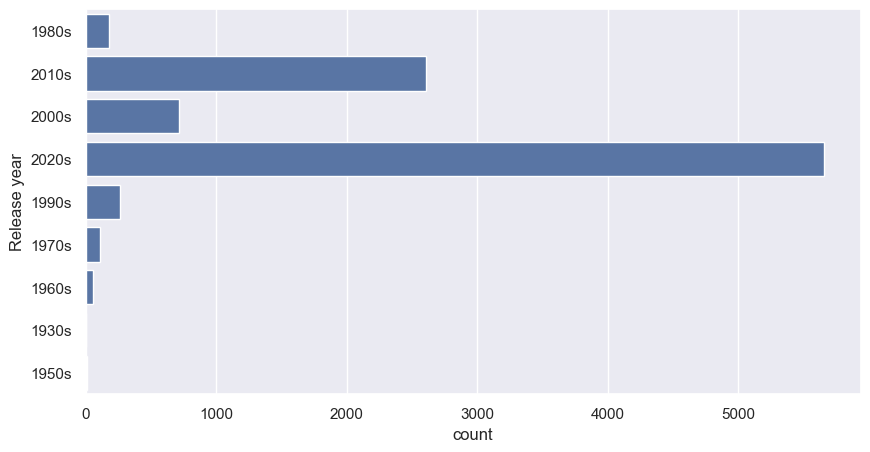

In [13]:
def extract_decade(year):
    start_period = int(year/10) * 10
    decade = '{}s'.format(start_period)
    return decade

sns.set(rc={'figure.figsize':(10 ,5)})
sns.countplot(music_df['Release year'].apply(extract_decade))

### Basic Analysis

#### Plotting Top 10 Most Popular Categories
Firstly, we plotted the average popularity of tracks within the Top 10 Categories. This was done by grouping the data by category column and calculating the mean popularity score for each category and plotting the results on a bar chart.

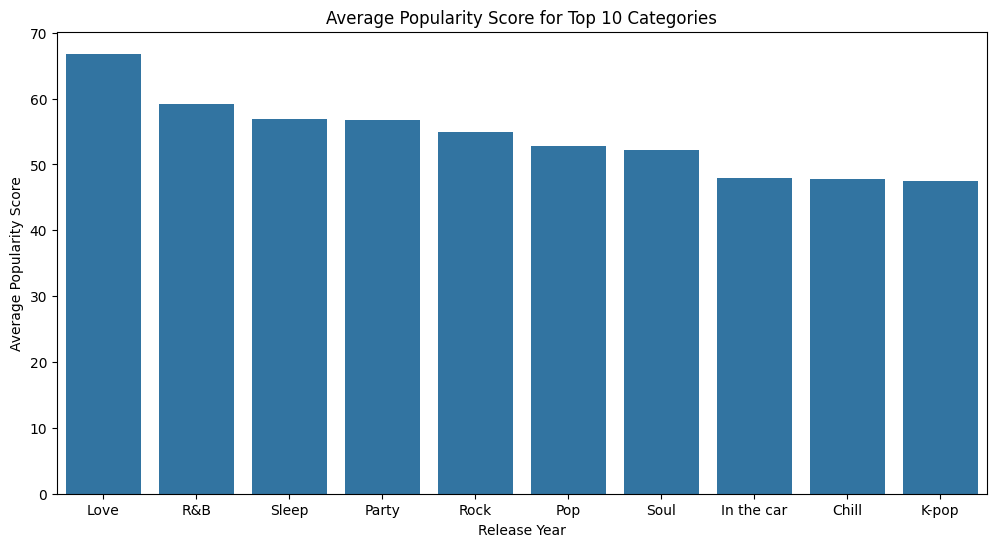

In [10]:
# group by categories, then calculate the average popularity
cat_popularity = music_df.groupby('Category')['Popularity'].mean().reset_index()
cat_popularity = cat_popularity.sort_values('Popularity',ascending=False) # sort top 10
cat_popularity = cat_popularity.head(10)

# plotting bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='Category', y='Popularity',data=cat_popularity)

# titles + lables
plt.title('Average Popularity Score for Top 10 Categories')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity Score')
plt.show()

#### The Popularity of Top 5 Categories Across the Years
We again sorted popularity score _by release year_ for the top 5 categories.

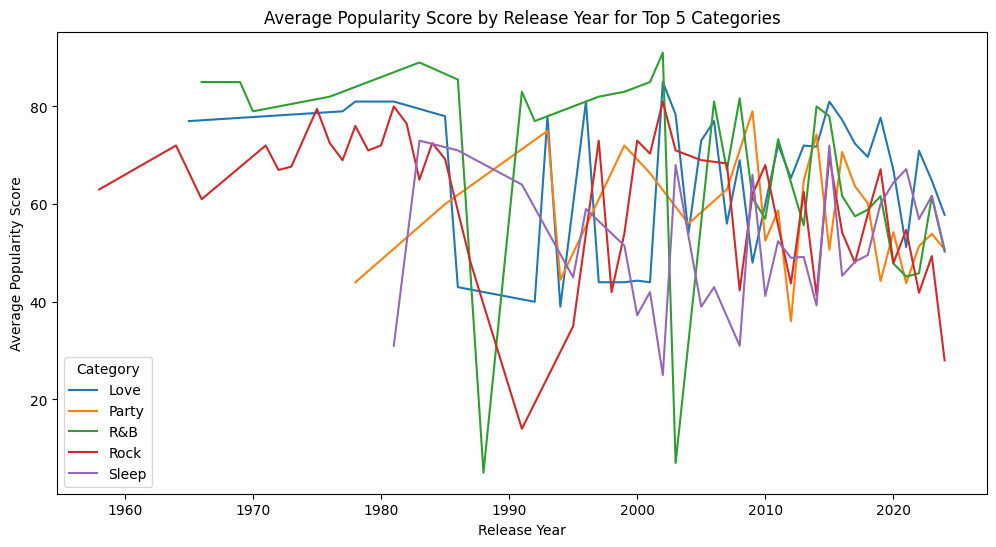

In [11]:
top_cats = music_df.groupby('Category')['Popularity'].mean().nlargest(5).index # again, finding top 5 categories by popularity
top_cats_df = music_df[music_df['Category'].isin(top_cats)] # filter the dataframe to only include these top 5

# group by categories and release year, then calculate the average popularity
avg_pop_by_year = top_cats_df.groupby(['Category', 'Release year'])['Popularity'].mean().reset_index()
sorted_avg_pop = avg_pop_by_year.sort_values(by=['Category', 'Release year'])

# plotting line
plt.figure(figsize=(12,6))
sns.lineplot(data=sorted_avg_pop, x='Release year', y='Popularity', hue='Category')

# titles + lables
plt.title('Average Popularity Score by Release Year for Top 5 Categories')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity Score')
plt.legend(title='Category')
plt.show()

Some simple insights we can take from the above graph are as follows:
- `Love` has been consistently popular over the recent years, in general never really dipping below a score of ~40 and is very often near the high 70s.
- `Sleep` saw a particular increase in popularity in 2020, the year of the Covid-19 pandemic. The increased stress and anxiety that people experienced during that time was potentially the dricing force in its popularity as people sought music designed to help relax and aid in sleep.
- **NOTE:** We can notice sharp dips in `R&B` in ~1988 and ~2003 when the popularity score plummets to near 0. This is may be an outlier result so we conducted a quick investigation below, filtering R&B songs with a populartiy score of under 70.

In [12]:
music_df[(music_df['Category'] == 'R&B') & (music_df['Popularity'] < 70) & (music_df['Release year'] < 2010)]

,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,duration
3069,5EcG8eMMlwkHRVa4aTR1qd,Breakin' Dishes,Rihanna,67,2007,R&B,0.800,0.660,8,-4.709,...,0.863,125.010,audio_features,5EcG8eMMlwkHRVa4aTR1qd,spotify:track:5EcG8eMMlwkHRVa4aTR1qd,https://api.spotify.com/v1/tracks/5EcG8eMMlwkH...,https://api.spotify.com/v1/audio-analysis/5EcG...,200573,4,3.34
3108,0gmE7pjFq2DyGRDOfphDwI,R&B,Matt Bianco,5,1988,R&B,0.688,0.986,4,-4.040,...,0.855,115.024,audio_features,0gmE7pjFq2DyGRDOfphDwI,spotify:track:0gmE7pjFq2DyGRDOfphDwI,https://api.spotify.com/v1/tracks/0gmE7pjFq2Dy...,https://api.spotify.com/v1/audio-analysis/0gmE...,289587,4,4.83
3112,0TeeS3KK0iIomihc2EBPgT,R&B,Ken Hirai,3,2009,R&B,0.747,0.884,10,-5.758,...,0.692,104.994,audio_features,0TeeS3KK0iIomihc2EBPgT,spotify:track:0TeeS3KK0iIomihc2EBPgT,https://api.spotify.com/v1/tracks/0TeeS3KK0iIo...,https://api.spotify.com/v1/audio-analysis/0Tee...,216573,4,3.61
3124,2PnGArl5oKXyrOSVCQgZ19,R&B,Quique Neira,7,2003,R&B,0.693,0.770,4,-5.637,...,0.517,90.014,audio_features,2PnGArl5oKXyrOSVCQgZ19,spotify:track:2PnGArl5oKXyrOSVCQgZ19,https://api.spotify.com/v1/tracks/2PnGArl5oKXy...,https://api.spotify.com/v1/audio-analysis/2PnG...,269853,4,4.50


**The above results illustrates some limitations of our dataset. It compromises of 200 songs over 50 categories, this results in ~10,000 tracks which provides a general overview across a variety of genres. However, as clearly seen above, it has limitation in depth for each category or year. Therefore, we should interpert results with caution and acknowledge the limited dataset, observations may be indicative but are definitely not definitive.**

Clearly, we don't have enough data on R&B songs in the 1980s and early 2000s

#### The Popularity of Various Categories Across the Years w/ Heat Map
Another way we can represnt the average `Popularity` score by `Release Year` and `Category` is by a heatmap as shown below. It follows almost the exact same methods as above with the added step of a pivot - create a matrix where rows are the release year, columns are the categories and the cell values are the popularity score.

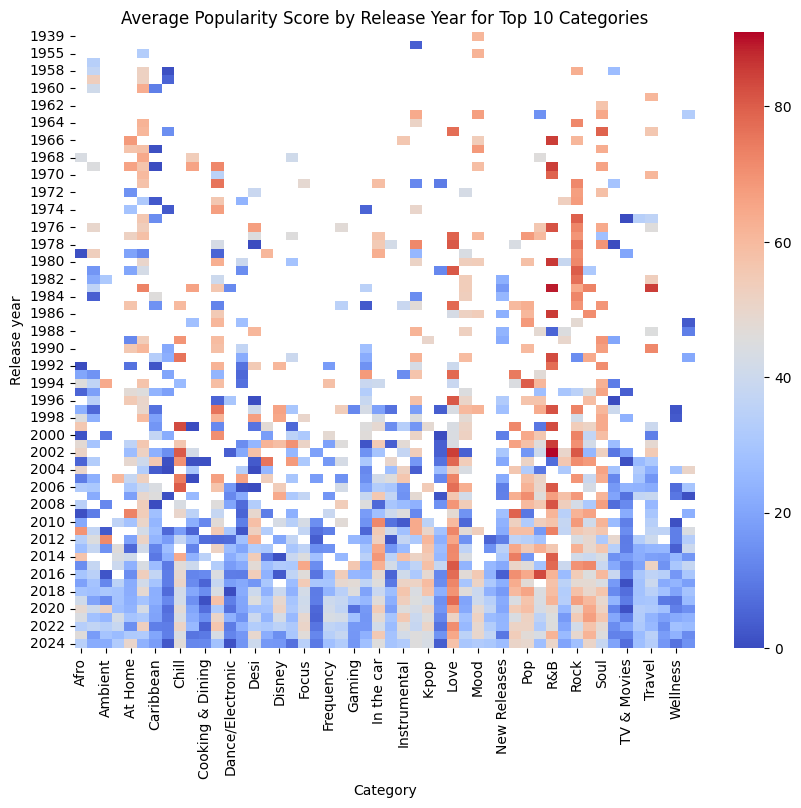

In [13]:
# ensure proper sorting by converting years to int
music_df['Release year'] = music_df['Release year'].astype(int)

year_cat_pop = music_df.groupby(['Release year', 'Category'])['Popularity'].mean().reset_index()
# pivot the df into a matrix
pop_matrix = year_cat_pop.pivot(index='Release year', columns='Category', values='Popularity')

diverging_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10,8))
sns.heatmap(pop_matrix,cmap=diverging_palette)

plt.title('Average Popularity Score by Release Year for Top 10 Categories')
plt.show()

It is now clearer to see the popularity of different categories change over time. `Cooking & Dining` seems to have lost popularity starting in the early 2000s, while `Love` and `R&B` again shows consistent popularity throughout the years.

#### Visualising Correlation of Different Audio Features
Next, we plotted all the audio features in a correlation matrix to try and find correlations between features like the duration of a song and it's affect on it's populartiy. This was done using the Pearson correlation.

In [14]:
numeric_data = music_df.select_dtypes(include=[int, float]) # only keep numerical data that can be computed
pearson_df = numeric_data.drop('duration_ms',axis=1).corr(method='pearson') # drop ms column and find Pearson correlation

pearson_df


,Popularity,Release year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration
Popularity,1.000000,-0.163956,-0.016373,0.089273,-0.004681,0.078746,0.006656,-0.052581,-0.068266,-0.182701,-0.007800,0.002203,0.001050,-0.004374,0.063735
Release year,-0.163956,1.000000,0.058270,-0.135256,-0.007528,-0.114217,-0.078894,0.088139,0.078662,0.144231,-0.037811,-0.154275,-0.019671,-0.020891,-0.220644
danceability,-0.016373,0.058270,1.000000,0.286773,0.021737,0.482858,-0.095559,0.234431,-0.358687,-0.324666,-0.061553,0.550805,0.083332,0.236589,-0.088238
energy,0.089273,-0.135256,0.286773,1.000000,0.060056,0.785084,-0.066086,0.121993,-0.735043,-0.472817,0.255464,0.423074,0.244768,0.181749,0.138322
key,-0.004681,-0.007528,0.021737,0.060056,1.000000,0.051315,-0.176379,0.009298,-0.052423,-0.023038,0.002853,0.040101,0.020506,0.018592,0.010179
loudness,0.078746,-0.114217,0.482858,0.785084,0.051315,1.000000,-0.063146,0.126082,-0.650132,-0.605788,0.138982,0.449223,0.226031,0.216695,0.120579
mode,0.006656,-0.078894,-0.095559,-0.066086,-0.176379,-0.063146,1.000000,-0.051813,0.067430,0.011088,-0.008126,-0.010331,-0.006237,-0.035229,0.015660
speechiness,-0.052581,0.088139,0.234431,0.121993,0.009298,0.126082,-0.051813,1.000000,-0.108372,-0.253354,0.177141,0.127763,0.067979,0.054123,-0.072553
acousticness,-0.068266,0.078662,-0.358687,-0.735043,-0.052423,-0.650132,0.067430,-0.108372,1.000000,0.433781,-0.138829,-0.314583,-0.228118,-0.190330,-0.115188
instrumentalness,-0.182701,0.144231,-0.324666,-0.472817,-0.023038,-0.605788,0.011088,-0.253354,0.433781,1.000000,-0.140040,-0.338401,-0.125840,-0.140433,-0.109102


We can analyse correlations more clearly using a heatmap visualisation.

[Text(0.5, 0, 'Popularity'),
 Text(1.5, 0, 'Release year'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'key'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'mode'),
 Text(7.5, 0, 'speechiness'),
 Text(8.5, 0, 'acousticness'),
 Text(9.5, 0, 'instrumentalness'),
 Text(10.5, 0, 'liveness'),
 Text(11.5, 0, 'valence'),
 Text(12.5, 0, 'tempo'),
 Text(13.5, 0, 'time_signature'),
 Text(14.5, 0, 'duration')]

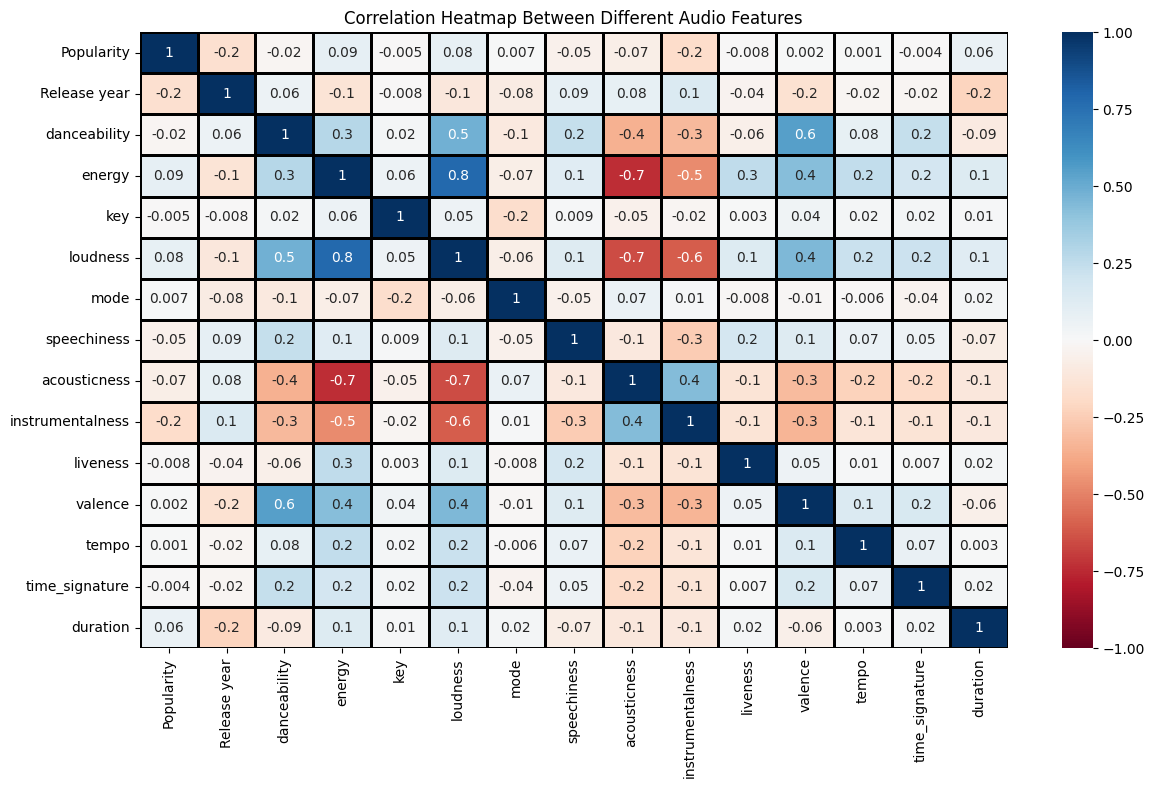

In [15]:
plt.figure(figsize=(14,8))
heatmap=sns.heatmap(pearson_df, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap="RdBu", linewidths=2, linecolor="Black")

heatmap.set_title('Correlation Heatmap Between Different Audio Features')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

- In terms of popularity correlations, we can see there is no one audio feature that contributes to the popularity of a song. 
- There is a strong level of correlation between `energy` and `loudness` which is as expected since louder tracks tend to feel more energetic. 
- On the other side of the spectrum, we can see a reasonable amount of negative correlation between `acousticness` and `energy` and `loudness`. Again, one may suspect this as tracks with higher acousticness tend to be less energetic, and quieter.
- There's no strong correlation between `Release year` and other audio features, implying that the characteristics of the music do not have a strong trend or shift over the years within the dataset.

#### Linear Regression Plots
These plots can help validate our assumptions of linear relationships between audio features and can be also useful for finding outliers. We will create a function that takes in the dataset, and two audio features and plot the respective regression plot 

In [16]:
def plot_regression(data, x_feature, y_feature, scatter_color='blue', line_color='black', marker_style='o'):
    sns.regplot(data=data, y=y_feature, x=x_feature,
                scatter_kws={'color': scatter_color},
                marker=marker_style, line_kws={'color': line_color}
               ).set(title=f'{y_feature} vs. {x_feature} Correlation')
    plt.show()

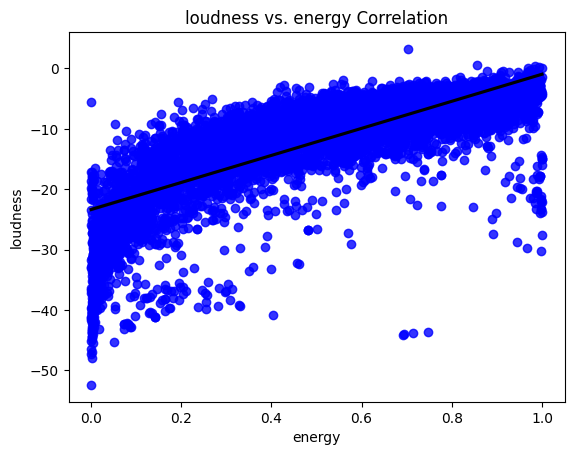

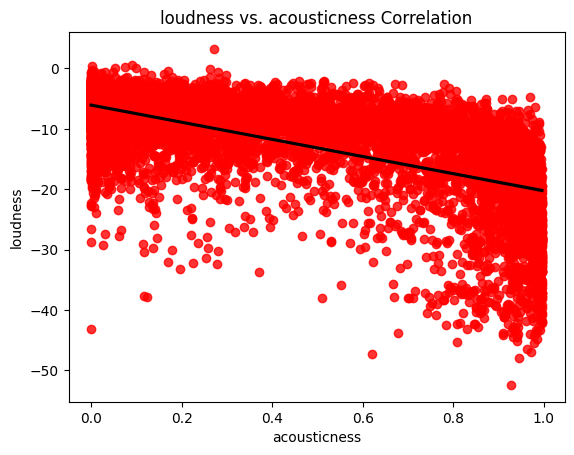

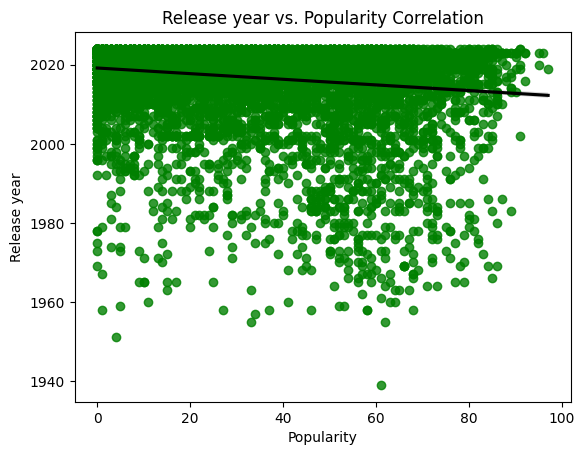

In [17]:
plot_regression(music_df, 'energy', 'loudness')
plot_regression(music_df, 'acousticness', 'loudness', 'red')
plot_regression(music_df, 'Popularity', 'Release year', 'green')


The regression plots tell the same story as the correlation matrix, with a near linear relationship between the energy of a song and its loudness and a negative correlation between a song's acousticness and it's volume. We also see there is absolutely no relationship between the release year of a song and it's popularity.

#### Duration of Tracks in Top 10 Categories
We then plotted the length of the average track in each category to try find a correlation between the duration of songs and their different genres.

/var/folders/pq/twcqc3s14kq0jvjm5c2dr5kw0000gn/T/ipykernel_5098/2093966872.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_10_categories_duration = music_df[tracks_df['Category'].isin(top_10_categories['Category'])].groupby('Category')['duration'].mean().reset_index()


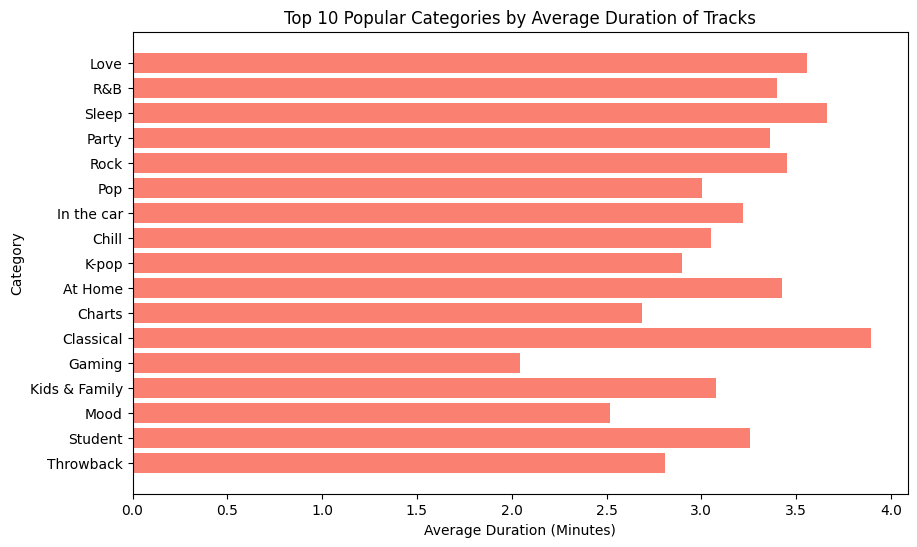

In [18]:
# finding top 10 categories by popularity
avg_pop_per_category = music_df.groupby('Category')['Popularity'].mean().reset_index() 
top_10_categories = avg_pop_per_category.sort_values(by='Popularity', ascending=False).head(10)

# calculate avg duration for top 10 categories
top_10_categories_duration = music_df[tracks_df['Category'].isin(top_10_categories['Category'])].groupby('Category')['duration'].mean().reset_index()

# sort in order of top 10 categories
top_10_categories_duration = top_10_categories_duration.merge(top_10_categories, on='Category', how='left').sort_values(by='Popularity', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_categories_duration['Category'], top_10_categories_duration['duration'], color='salmon')

plt.xlabel('Average Duration (Minutes)')
plt.ylabel('Category')
plt.title('Top 10 Popular Categories by Average Duration of Tracks')
plt.gca().invert_yaxis() # invert axis to have the most popular category at the top
plt.show()


`Love` and `At Home` have the longest average track durations. Songs in the Love category tend to have more extended compositions, things such as ballads or love songs. The At Home category may contains music for when you're preparing dinner, or cleaning the house and may tend to offer longer tracks for those prolonged activities. In contrast, the category with the shortest average duration is `Gaming` which may feature songs that are higher energy and more dynamic to fit the atmosphere of gaming.

### Music Over the Times
Next, we analyzed various aspects of music over the years.

#### Duration of Song over the Years
We plotted the average duration of songs over the years and obtained the following plot.

/var/folders/pq/twcqc3s14kq0jvjm5c2dr5kw0000gn/T/ipykernel_5098/78588335.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_duration, x='Release year', y='duration', palette='viridis')


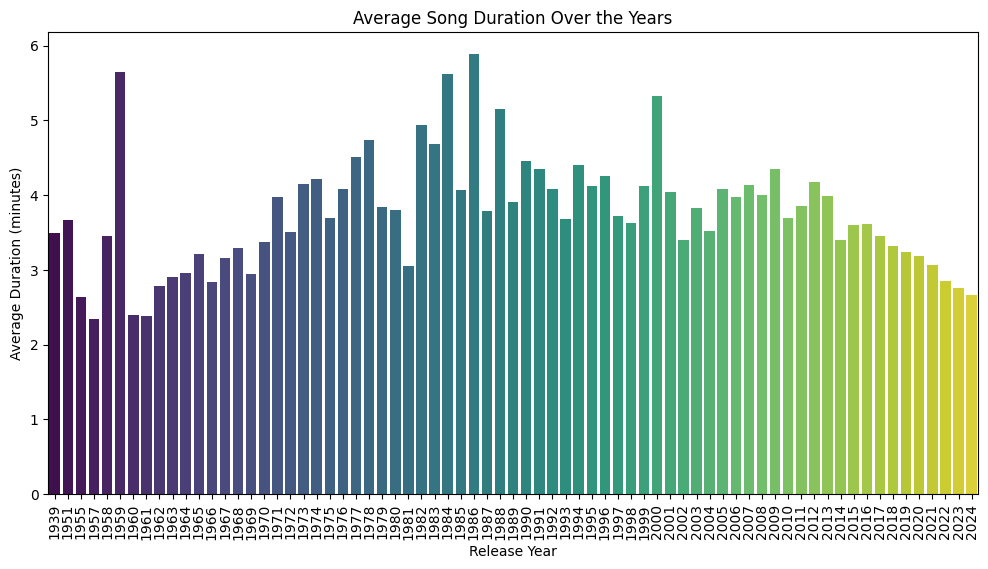

In [19]:
yearly_duration = music_df.groupby('Release year')['duration'].mean().reset_index()
# Plotting the trend of average song duration over the years
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_duration, x='Release year', y='duration', palette='viridis')

plt.title('Average Song Duration Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=90)

plt.show()

We see some obvious outliers due to our limited dataset, such in the year 2000. However, an interesting observation we can make is the steady decreasing duration of songs from ~2015. This is most likely related to apps such as Musically (merged into TikTok) that was released in 2014. Platforms such as Musically and TikTok started this trend for shorter length songs as artists and producers focus more on creating catchy hooks for the 15-30 seconds that will be played in the TikTok videos. Their strategy is to influence the TikTok algorithm for a viral hit, aiming to get a snippet of the song into the users' head after a few swipes. This has been dubbed the "TikTokification" of music. If we look back, we previously saw the average time for tracks in the `Charts` category be only ~2.5 mins - showing the popular songs nowadays have definitely gotten shorter.

Next, we extracted the number of tracks we have from each decade. Clearly from the chart below, our dataset is primarily made of songs released in the 2010s and 2020s, with ~200 tracks from the 80s and 90s and ~800 tracks from the 2000s.

<Axes: xlabel='count', ylabel='Release year'>

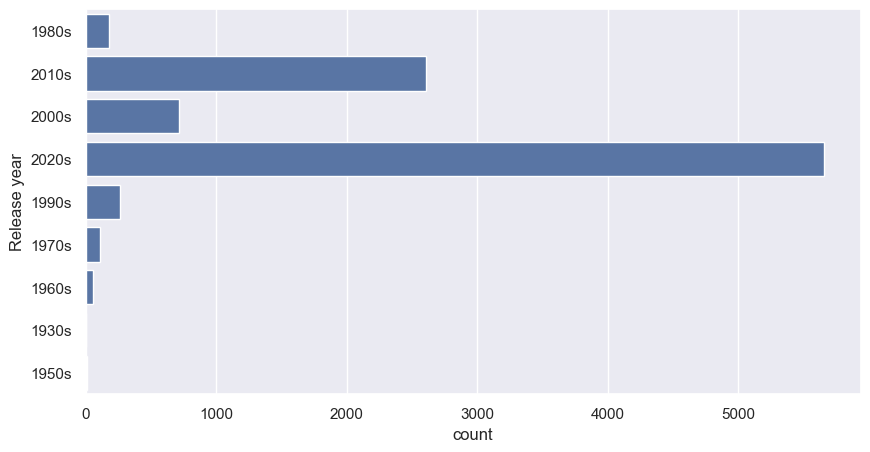

In [20]:
def extract_decade(year):
    start_period = int(year/10) * 10
    decade = '{}s'.format(start_period)
    return decade

sns.set(rc={'figure.figsize':(10 ,5)})
sns.countplot(music_df['Release year'].apply(extract_decade))

#### Audio Features Over the Years
We then analysed songs' audio charateristics and how they have changed over the years, only taking into account tracks after 1980 for the most accurate analysis.

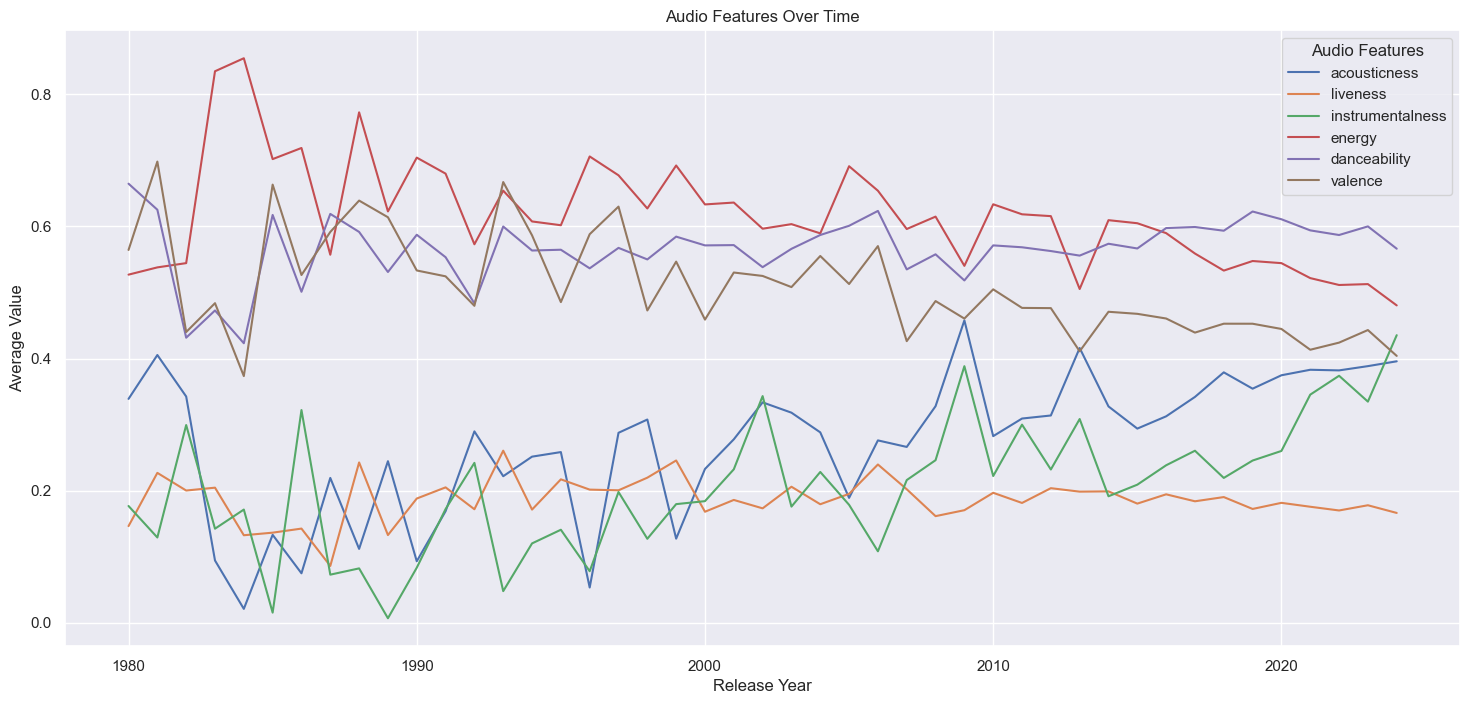

In [21]:
audio_features = ['acousticness', 'liveness', 'instrumentalness', 'energy', 'danceability', 'valence']
feature_by_year = music_df.groupby('Release year')[audio_features].mean().reset_index()
features_past_80s = feature_by_year[feature_by_year['Release year'] >= 1980] # only taking tracks from past the 80s

plt.figure(figsize=(18, 8))
for feature in audio_features:
    sns.lineplot(data=features_past_80s, x='Release year', y=feature, label=feature)

plt.title('Audio Features Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Value')
plt.legend(title='Audio Features')
plt.show()

Some key insights from the chart include `valence` trending downwards over time, indicating that in recent years there is a trend towards more somber music. This may be linked to the increase in `instrumentalness` in songs since the 90s and the decrease in `energy` receently.

#### Plotting the Audio Features for Top 10 Categories

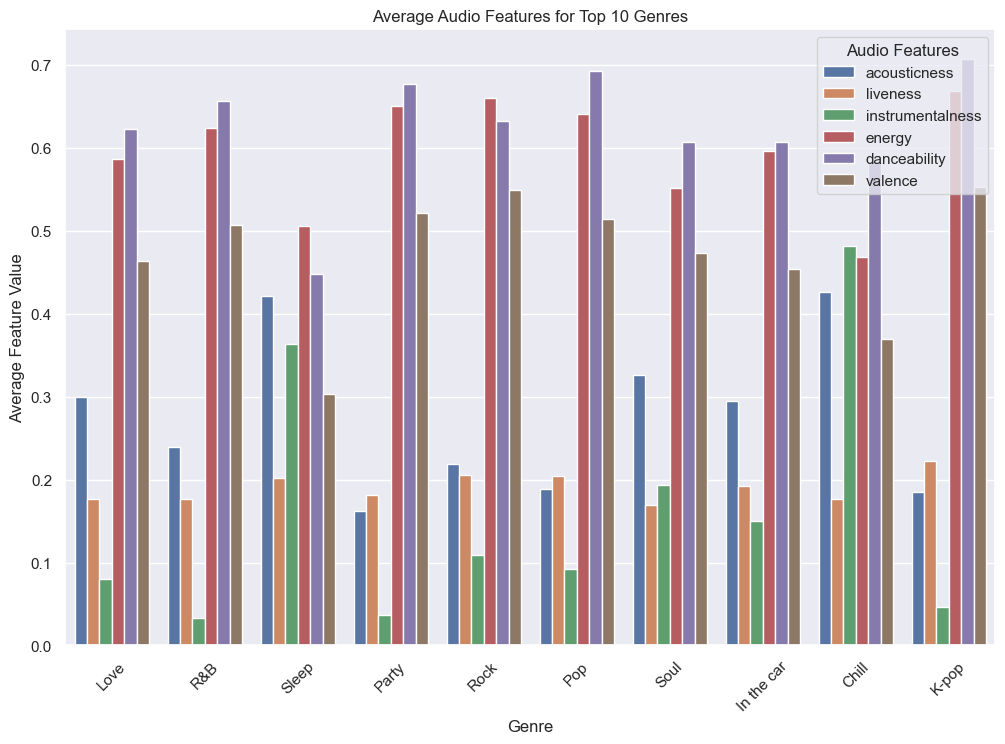

In [22]:
# calculate the avg popularity and audio features for each category
genre_averages = music_df.groupby('Category').agg({
    'Popularity': 'mean', **{feature: 'mean' for feature in audio_features}}).reset_index()

# sort top 10 categories by popularity
top_genres = genre_averages.sort_values(by='Popularity', ascending=False).head(10)

# plotting
melted = top_genres.melt(id_vars='Category', value_vars=audio_features, var_name='Feature', value_name='Value')
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Value', hue='Feature', data=melted)

plt.title('Average Audio Features for Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Average Feature Value')
plt.xticks(rotation=45)
plt.legend(title='Audio Features')
plt.show()

Both `energy` and `danceability` are very high across all the shown categories, except for `sleep`, indicating that popular music tends to be more energetic and is common in genres that can be played in social settings like parties or in feel-good ads.  
Features like `acousticness` and `instrumentalness` are as expected highest in the Sleep category. Tracks in this category are usually non-vocal and have a preference for 'unplugged' instrumentals.  
`K-Pop` showed the highest level of valence suggesting that it's more lively and active which would be needed for a genre that incorporates a large amount of live performances. We can also see similarities in how `Love` songs and `R&B` songs sound, having a similiar audio profile.

## Music Recommendation System

Using our dataset, we tried to build a simple music recommendation system which will take in a song and output similar songs that sound like it.

### Normalise the Data

Inspecting the datasets numerical values, we can see large variations in scale. We first need to normalise this data to ensure that audio features with larger scales don't dominate our Manhattan distance calculations and skew our results.

In [23]:
music_df.tail(3)

,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,duration
9608,1d3AW9yAPhQo0J6RkxGyMq,Travel (Remastered),Lotus,9,2014,Travel,0.670,0.799,7,-10.001,...,0.497,117.012,audio_features,1d3AW9yAPhQo0J6RkxGyMq,spotify:track:1d3AW9yAPhQo0J6RkxGyMq,https://api.spotify.com/v1/tracks/1d3AW9yAPhQo...,https://api.spotify.com/v1/audio-analysis/1d3A...,341480,4,5.69
9609,54B8Dfq87VCwQwrWgdZzIJ,Travel,Jon Trees,8,2021,Travel,0.585,0.562,6,-9.113,...,0.522,84.061,audio_features,54B8Dfq87VCwQwrWgdZzIJ,spotify:track:54B8Dfq87VCwQwrWgdZzIJ,https://api.spotify.com/v1/tracks/54B8Dfq87VCw...,https://api.spotify.com/v1/audio-analysis/54B8...,145789,4,2.43
9610,0ZhSQIDIv0CWVc0Vt1aiBm,Hook,Blues Traveler,44,2002,Travel,0.536,0.826,9,-4.348,...,0.819,165.324,audio_features,0ZhSQIDIv0CWVc0Vt1aiBm,spotify:track:0ZhSQIDIv0CWVc0Vt1aiBm,https://api.spotify.com/v1/tracks/0ZhSQIDIv0CW...,https://api.spotify.com/v1/audio-analysis/0ZhS...,288507,4,4.81


The next cell defines and calls a function which normalises a given column, `col`, within a given DataFrame `df`. We scale the data values within a column to a range between 0 and 1. 

- First we subtract the minimum value in the column from each value, and then divide by the range of the column (maximum value - minimum value). This is to ensure that all numerical features contribute equally to the distance calculation that will follow.
- After defining the function, we select all numerical columns in `music_df` and apply the `normalize_column` function to each column. 

In [24]:
def normalize_column(df, col):
    max_d = df[col].max()
    min_d = df[col].min()
    df[col] = (df[col] - min_d)/(max_d - min_d)

num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericals = music_df.select_dtypes(include=num_types)
        
for col in numericals.columns:
    normalize_column(music_df,col)

music_df.head(3)

,Track ID,Track name,Artist name,Popularity,Release year,Category,danceability,energy,key,loudness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,duration
0,6DshyLFOY859M1ERk0h54h,New Release,Killing Time,0.226804,0.588235,New Releases,0.325581,0.713994,0.363636,0.699752,...,0.378378,0.564105,audio_features,6DshyLFOY859M1ERk0h54h,spotify:track:6DshyLFOY859M1ERk0h54h,https://api.spotify.com/v1/tracks/6DshyLFOY859...,https://api.spotify.com/v1/audio-analysis/6Dsh...,0.015002,0.8,0.015011
1,4DZghpw50ZnO3ckfDuNkft,New Religion,The Heydaze,0.546392,0.917647,New Releases,0.542973,0.862997,0.636364,0.861771,...,0.484484,0.436836,audio_features,4DZghpw50ZnO3ckfDuNkft,spotify:track:4DZghpw50ZnO3ckfDuNkft,https://api.spotify.com/v1/tracks/4DZghpw50ZnO...,https://api.spotify.com/v1/audio-analysis/4DZg...,0.036190,0.8,0.036152
2,0KbTsCQkdNGnkrea1vA4eG,Morning Has Broken (New Release) (with Diana K...,Art Garfunkel,0.443299,0.741176,New Releases,0.255814,0.205984,0.181818,0.685395,...,0.228228,0.474928,audio_features,0KbTsCQkdNGnkrea1vA4eG,spotify:track:0KbTsCQkdNGnkrea1vA4eG,https://api.spotify.com/v1/tracks/0KbTsCQkdNGn...,https://api.spotify.com/v1/audio-analysis/0KbT...,0.030277,0.6,0.030273


### KMeans Clustering
Next, we used K-Means clustering to group songs into 'clusters' based on the numerical values of their audio features. K-Means is an unsupervised ML algorithm that divides a dataset into a set number of clusters. Each data point is joined to a cluster with the nearest mean in order to reduce the variance in each cluster while maximising variance between different clusters. We use K-Means to cluster songs based on their audio features so we can recommend songs that sound similar - or at least have similiar sound charateristics.

0    0.555556
1    1.000000
2    1.000000
3    0.555556
4    0.444444
5    1.000000
6    0.000000
7    1.000000
8    0.111111
9    0.111111
Name: cluster_category, dtype: float64


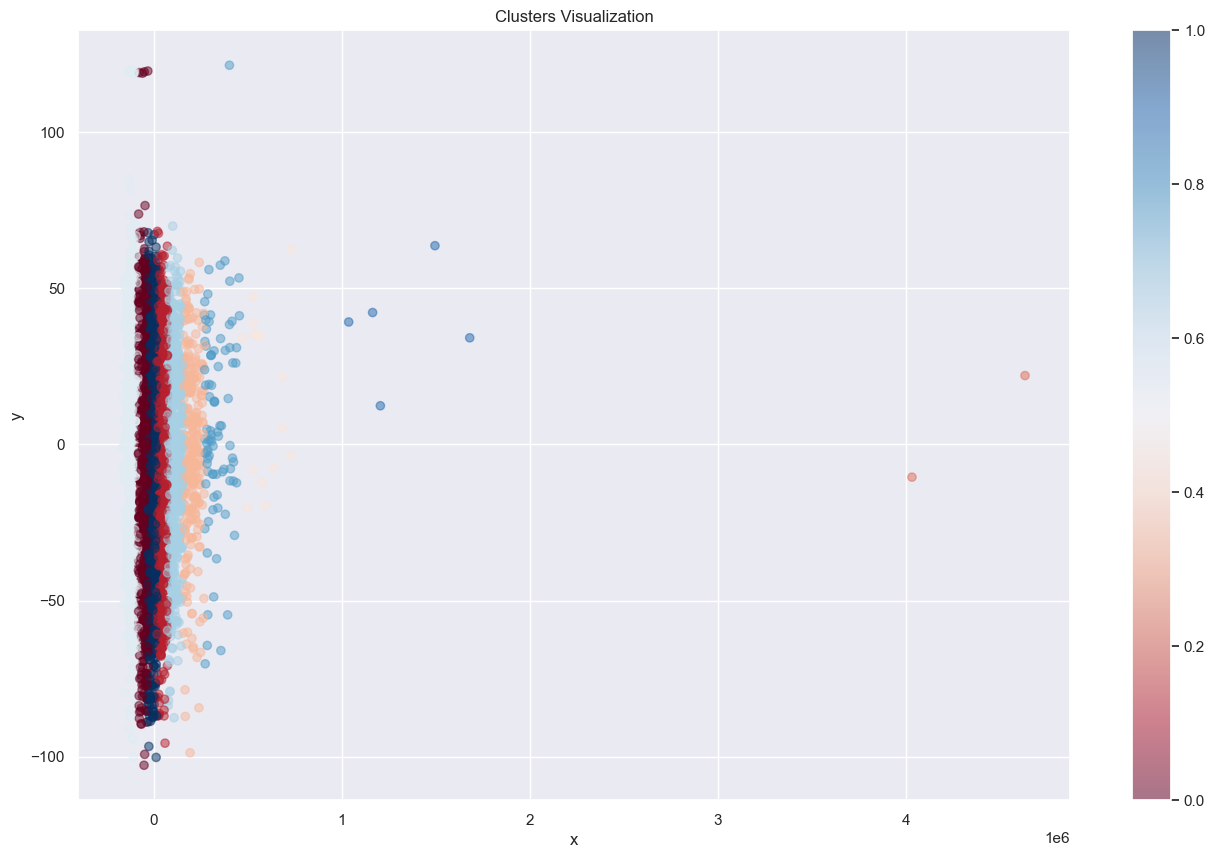

In [30]:
# initialize the KMeans clustering algorithm with 10 clusters
kmeans_model = KMeans(n_clusters=10)

# fit the model on the numerical features of the dataset and predict the cluster assignments for each song.
cluster_categories = kmeans_model.fit_predict(numericals)

# add the clusters as a new column in music_df 
music_df['cluster_category'] = cluster_categories

normalize_column(music_df, 'cluster_category')
print(music_df['cluster_category'][:10])

# visualising the cluster using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numericals)
music_df['pca_one'] = pca_result[:,0]
music_df['pca_two'] = pca_result[:,1]

plt.figure(figsize=(16,10))
plt.scatter(music_df['pca_one'], music_df['pca_two'], c=music_df['cluster_category'], cmap='RdBu', alpha=0.5)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clusters Visualization')
plt.show()

In the above graph, you can see a dense region of data points along the left side, indicating a group of songs with similar features. The clusters are differentiated mostly by their values along the x axis - the direction of greatest variance. We can see however several points spread out to the right, which may be songs that are very different from the main group or could be a result of how PCA has projected the data into two dimensions.

### Recommendation System
The `MusicRecommender` class is designed to give song recommendations from our dataset based on the similarity of songs. The similarity is calculated using the _Manhattan_ distance between the features of the songs.  

The class is initialized with `recommendation_data` - a DataFrame containing the songs and their features.  

`update_data(self, new_data)`: If our song database changes, this method can be called to replace the old dataset with the new one.  

`get_recommendations()`: This is the main method of the class, used to retrieve song recommendations.

- It first locates the target song within the dataset.
- It then excludes the target song to avoid recommending the same song.
- Next, it iterates over the remaining songs in the dataset, calculating the Manhattan distance to each song based on their numerical features. Non-numerical columns are ignored in this calculation.
- The distances are stored and then used to sort the dataset, placing the most similar songs (those with the smallest distances) at the top.
- The method finally returns the specified number of top songs as recommendations, including the artist's name and track name.

The class uses Manhattan distance to calculate the similarity between songs. This distance sums the absolute values of the differences between the coordinates of a pair of points. In our context, it compares the absolute differences between the features of two songs.

In [26]:
class MusicRecommender():
    def __init__(self, recommendation_data):
        self.recommendation_data = recommendation_data
    
    def update_data(self, new_data):
        self.recommendation_data = new_data
    
    def get_recommendations(self, target_song, num_recommendations=1):
        # list to hold the Manhattan distances
        song_distances = []
        
        # find the target song in the dataset
        target_song_data = self.recommendation_data[
            self.recommendation_data['Track name'].str.lower() == target_song.lower()
        ].head(1).values[0]
        # exclude the target song from the dataset to avoid recommending the same song
        dataset_wo_target = self.recommendation_data[
            self.recommendation_data['Track name'].str.lower() != target_song.lower()
        ]
        
        # loop through the dataset and calculate the Manhattan distance from the target song
        for compared_song in tqdm(dataset_wo_target.values):
            distance = 0
            # calculate distance for each feature (ignoring non-numerical columns)
            for feature_index in np.arange(len(dataset_wo_target.columns)):
                if feature_index not in [0, 1, 2, 4, 5, 17, 18, 19, 20, 21, 22, 23, 24]:
                    distance += np.absolute(float(target_song_data[feature_index]) - float(compared_song[feature_index]))
            song_distances.append(distance)
        
        # add the distances to the dataset as a new column
        dataset_wo_target['distance'] = song_distances
        
        # sort by closest songs first
        sorted_songs_by_distance = dataset_wo_target.sort_values('distance')
        cols = ['Artist name', 'Track name']
        return sorted_songs_by_distance[cols][:num_recommendations]


In [27]:
recommender = MusicRecommender(music_df)
recommender.get_recommendations('Love Story', 3)

100%|██████████| 9607/9607 [00:00<00:00, 60202.50it/s]
/var/folders/pq/twcqc3s14kq0jvjm5c2dr5kw0000gn/T/ipykernel_5098/1058363680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_wo_target['distance'] = song_distances


,Artist name,Track name
4201,Luke Bryan,What Makes You Country
6927,KOLIDESCOPES,Focus
1270,J. Cole,Work Out


In [28]:
recommender.get_recommendations('See You Again (From "Fast & Furious 7")', 3)

100%|██████████| 9610/9610 [00:00<00:00, 58345.71it/s]
/var/folders/pq/twcqc3s14kq0jvjm5c2dr5kw0000gn/T/ipykernel_5098/1058363680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_wo_target['distance'] = song_distances


,Artist name,Track name
9550,Traveling Wilburys,Last Night
3134,Hayce Lemsi,R&B
5638,Lewis Capaldi,Pointless


The recommender is somewhat accurate but due to our very limited dataset, songs recommendations can be made more accurate. Spotify's recommender algorithm would be a lot more advanced using Natural Language Processing, audio analysis, and collaborative filtering to understand their user and their favourite songs more deeply. Their ML models would always be continously learning and imprving recommendations based on user interactions and listens.

# Conclusion
### Key Insights
In this assignment we looked at the analysis of the factors that contribute to the popularity of a song and how these factors vary across genres and different time periods. We also built a basic music recommendation system. As we might expect, the audio patterns for certain genres such as Love and R&B were quite similar perhaps due to the emotion behind both genres or the expressive and emotive vocal styles behind both genres. It was also interesting to see how music has changed over the years, the decreasing duration of songs and increase in danceability since the mid-2010s is largerly caused by the new format of content creation e.g. TikTok, Instagram Reels, YouTube Shorts etc.  
It was also interesting to see very little correlation between different audio features, except for 'energy' and 'loudness' and how these audio features did not have an effect on the songs popularity score. In our KMeans clustering we did see some severe outliers when comparing audio features, which may again be due to our limited dataset, overall though we could see the amount of songs that sound more similar to each other.

### Challenges Faced
One particular challenge of using the free Spotify API is the data inconsistency. When collecting tracks, there were many duplicates with different versions of the same song as well as missing audio features for some songs too. This made forced us to clean some of the data in Task 1 when creating the audio features DataFrame. The way we collected data too, collecting tracks from various categories led to duplicates when a track could be featured in 2+ categories, something I can learn from.

### Suggestions for further analysis
- The analysis could be extended to a larger number of tracks to further investigate the idea of 'TikTokification', to see if songs are really decreasing over time and to get a real sense of how music sounded in the pre-2000s.
- If further data was available, we could consider whether the music preferences change seasonally - are certain genres more popular during different times of the year?
- Involve social media analysis, we could try find a correlation between mentions of artists and tracks and their popularity on Spotify. 
- Our music recommendation tool can benefit from a much, much larger dataset and can use more complicated methods to recommend songs.